## Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

For this project, we will be working to understand the results of an A/B test run by an e-commerce website. Our goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
### Part I - Probability

Import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

Read in the data and look at the top few rows.

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


Number of rows in the dataset.

In [3]:
df.shape[0]

294478

Number of unique users in the dataset.

In [4]:
df['user_id'].nunique()

290584

Proportion of users converted.

In [5]:
df['converted'].mean()

0.11965919355605512

Number of times the **new_page** and **treatment** don't line up.

In [6]:
count_np_not_treat = df.query('landing_page == "new_page" & group != "treatment"')
count_op_not_ctrl = df.query('landing_page == "old_page" & group != "control"')
count_np_not_treat.shape[0] + count_op_not_ctrl.shape[0]

3893

How many rows have missing values?

In [7]:
df.isnull().any(axis=1).sum()

0

For the rows where **new_page** and **treatment** don't line up or **old_page** and **control** don't line up, we cannot be sure if these rows truly received the new or old page.

Drop these rows and create a new dataframe.

In [8]:
df2 = df.query('landing_page == "new_page" & group == "treatment" | landing_page == "old_page" & group == "control"')

How many rows in **df2**?

In [9]:
df2.shape[0]

290585

How many pages are there where **treatment** doesn't line up with **new_page**?

In [10]:
# Double Check all of the correct rows were removed for new pages - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

How many pages are there where **control** doesn't line up with **old_page**?

In [11]:
# Double Check all of the correct rows were removed for old pages - this should be 0
df2[((df2['group'] == 'control') == (df2['landing_page'] == 'old_page')) == False].shape[0]

0

How many unique **user_id**s are in **df2**?

In [12]:
total_users = df2['user_id'].nunique()
total_users

290584

There is one **user_id** repeated in **df2**.

In [13]:
df2[df2.duplicated('user_id')]['user_id']

2893    773192
Name: user_id, dtype: int64

Row information for the repeat **user_id**.

In [14]:
df2[df2.duplicated('user_id', keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


Remove **one** of the rows with a duplicate **user_id**, but keep dataframe as **df2**.

In [15]:
df2 = df2.drop(1899)

Confirm that one row has been deleted, and only one remain for that user.

In [16]:
df2.query('user_id == 773192')

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


Probability of an individual converting regardless of the page they receive.

In [17]:
df2.query('converted == 1')['user_id'].nunique() / total_users

0.11959708724499628

Probability of an individual converting given that he was in the `control` group.

In [18]:
total_users_control = df2.query('group == "control"')['user_id'].nunique()
user_control_conv = df2.query('group == "control" & converted == 1')['user_id'].nunique() / total_users_control
user_control_conv

0.1203863045004612

Probability of an individual converting given that he was in the `treatment` group.

In [19]:
total_users_treat = df2.query('group == "treatment"')['user_id'].nunique()
user_treat_conv = df2.query('group == "treatment" & converted == 1')['user_id'].nunique() / total_users_treat
user_treat_conv

0.11880806551510564

Probability that an individual received the new page.

In [20]:
df2.query('group == "treatment"')['user_id'].nunique() / total_users

0.5000619442226688

#### Observations
The conversion rate of users in the `control` group was 0.1203 while the conversion rate of users in the `treatment` group was 0.1188. The conversion rate between the two groups is almost the same, with the `control` group being slightly higher. Also the porportion of users receiving either group was evenly split at 50%.

We can therefore conclude that there is not sufficient evidence to suggest that the new page performs any better than the old page.

<a id='ab_test'></a>
### Part II - A/B Test
#### Null and Alternative hypothesis
If we want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, then the following is the null and alternative hypothesis.

Null hypothesis ($H_0$) is that the new page ($P_{new}$) will not have a conversion rate of 5% or higher than the old page ($P_{old}$).

Alternative hypothesis ($H_1$) is that the new page ($P_{new}$) will have at least a 5% or higher conversion rate than the old page ($P_{old}$).

Or stating this another way:

$H_0$ : $p_{new}$ &leq; $p_{old}$<br>
$H_1$ : $p_{new}$ &gt; $p_{old}$

#### Sampling distribution simulation
Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page.

Use a sample size for each page equal to the ones in **ab_data.csv**.

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.

**Convert rate** for both $p_{new}$ and $p_{old}$ is:

In [21]:
convert_mean = df2.query('converted == 1')['user_id'].nunique() / total_users
convert_mean

0.11959708724499628

Find $n_{new}$

In [22]:
n_new = df2.query('group == "treatment"')['user_id'].nunique()
n_new

145310

Find $n_{old}$

In [23]:
n_old = df2.query('group == "control"')['user_id'].nunique()
n_old

145274

Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null. Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [24]:
new_page_converted = np.random.choice([0, 1], size=n_new, p=[(1 - convert_mean), convert_mean])

Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null. Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [25]:
old_page_converted = np.random.choice([0, 1], size=n_old, p=[(1 - convert_mean), convert_mean])

Find $p_{new}$ - $p_{old}$ for our simulated values.

In [26]:
new_page_converted.mean() - old_page_converted.mean()

0.00050703151031866733

Simulate 10,000 $p_{new}$ - $p_{old}$ values and store values in numpy array called **p_diffs**

In [27]:
p_diffs = []
for _ in range(10000):
    new_page_conv = np.random.choice([0, 1], size=n_new, p=[(1 - convert_mean), convert_mean])
    old_page_conv = np.random.choice([0, 1], size=n_old, p=[(1 - convert_mean), convert_mean])
    p_diffs.append(new_page_conv.mean() - old_page_conv.mean())
p_diffs = np.array(p_diffs) #convert to numpy array

Observed difference of conversion rate between users from the `treatment` group and the `control` group.

In [28]:
obs_diff = user_treat_conv - user_control_conv 
obs_diff

-0.0015782389853555567

Plot a histogram of the **p_diffs**

In our observed difference, slightly more users from the `control` group converted than users from the `treatment` group. This is shown on the graph where the red line (observed difference) is to the left of the mean.

Our sampling distribution of 10,000 samples also shows slightly more samples falling to the left side of the mean. We can see this by the slightly greater height of the bars to the left side of the histogram plot.

So in conclusion the plot does look like what we would expect.

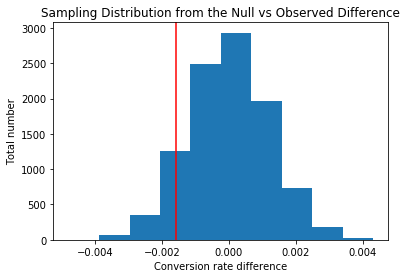

In [29]:
plt.hist(p_diffs)
plt.xlabel('Conversion rate difference')
plt.ylabel('Total number')
plt.title('Sampling Distribution from the Null vs Observed Difference')
plt.axvline(obs_diff, c='red');

Proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**.

In [30]:
(p_diffs > obs_diff).mean()

0.90820000000000001

#### Results
The result we have just computed is called the p-value in scientific studies.

For our alternative hypothesis to be true, that is, the new page has a greater of conversion rate than the old page, the p-value must be less than our Type I error rate of 5%. In this case our p-value is 0.905 which is much greater than our Type I error rate of 0.05. Therefore we can conclude that we fail to reject the null hypothesis.

#### An alternative method: Z-Test
We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 

We fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [31]:
import statsmodels.api as sm

#Number of conversions for each page
convert_old = df2.query('group == "control" & converted == 1')['user_id'].nunique()
convert_new = df2.query('group == "treatment" & converted == 1')['user_id'].nunique()

#n_old and n_new previously calculated

C:\Users\60067186\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Use `stats.proportions_ztest` to compute test statistic and p-value.

In [32]:
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')
(z_score, p_value)

(-1.3109241984234394, 0.90505831275902449)

Calculate critical value at 95% confidence.

In [33]:
from scipy.stats import norm
norm.ppf(1-(0.05/2))

1.959963984540054

#### Results
The z-score is a measure of standard deviation. In this case the z-score is -1.31. As it is negative that just means it is  1.31 standard deviations below the mean. The critical value at 95% confidence is 1.96. For us to reject the null hypothesis the magnitude of the z-score must be greater than our critical value. In this case 1.31 is less than 1.96 therefore we fail to reject the null hypothesis.

The p-value is also similar to our previous value that was manually calculated. This also suggests that we fail to reject the null hyposthesis.


<a id='regression'></a>
### Part III - A regression approach

We will now see that the result acheived in the previous A/B test can also be acheived by performing regression.

Since each row is either a conversion or no conversion we will be performing logistic regression.

The goal is to use **statsmodels** to fit the regression model previously specified to see if there is a significant difference in conversion based on which page a customer receives.

In [34]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


Create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [35]:
df2['intercept']=1
df2[['old_page','ab_page']] = pd.get_dummies(df2['group'])
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,old_page,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0


Use **statsmodels** to import the regression model. Instantiate the model, and fit the model using the two columns previously created to predict whether or not an individual converts. Provide a summary of the model.

In [36]:
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Tue, 11 Sep 2018   Pseudo R-squ.:               8.077e-06
Time:                        10:25:08   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

#### Explanation why the difference in p-value in the two previous tests
The p-value associated with ab_page is 0.190. It differs to the value found in Part II where the manually calculated p-value and the z-test both yielded a p-value of about 0.9. 

In Part II - A/B test, the alternative hypothesis is if the conversion rate for the new page is **greater than** the conversion rate for the old page. This means that we are performing a one-tailed test.

In Part III - Logistic regression test, the alternative hypothesis is if the conversion rate is **equal to** 1 as opposed to 0. This means that we are performing a two-tailed test.

Given this, the p-value is therefore different between the two tests. The p-value in the logistic regression test is about twice (0.190) that of the A/B test (~0.9).

#### Other factors to consider

It is good to consider other factors to add to the regression model. For example if the e-commerce website was geared towards gender, an online hardware store for example, then it would be prudent to also include gender as another explantory variable. This would ensure that the data is better fitted to the regression line.

We also have to make sure that other variables added to the model does not already have an association with any of the existing explanatory variables or else it will skew the results. This is known as multicollinearity. One way to test is to calculate the Variance Inflaction Factor (VIF). As a rule of thumb, values greater than 10 definitely have multicollinearity where as values > 5 may have multicollinearity.

Another way to check if a variable should remain in the model is by looking at the R-squared value. In the case of logistic regression this is a psuedo r-squared value. If it increases and is closer to 1 then that means the data is better fitted to the regression line and the variable probably should remain. If it decreases and is closer to 0 then that means the data is worse fitted and the variable should probably not be included.

#### Add a new variable to the model
Now along with testing if the conversion rate changes for different pages, we will also add an effect based on which country a user lives. 

Read in the **countries.csv** dataset and merge together the datasets on the approporiate rows.

In [37]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,old_page,ab_page
user_id,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1


How many different countries are there in the dataset?

In [38]:
df_new['country'].value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

Create the necessary dummy variables.

In [39]:
df_new[['country_CA','country_UK','country_US']] = pd.get_dummies(df_new['country'])
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,old_page,ab_page,country_CA,country_UK,country_US
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1,0,1,0


Provide the summary results.

In [40]:
logit_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'country_UK','country_US']])
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Tue, 11 Sep 2018   Pseudo R-squ.:               1.521e-05
Time:                        10:25:09   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
country_UK     0.0507      0.028      1.786      0.074      -0.005       0.106
country_US     0.0408      0.027      1.518      0.129      -0.012       0.093
==============================================================================
"""

Get the exponential for the coeffiecient for the UK and US.

In [41]:
np.exp(0.0507), np.exp(0.0408)

(1.0520072437650141, 1.0416437559600236)

#### Results
We used Canada as the baseline value. This means that users from UK are 1.05 times or about 5% more likely to convert than users from Canada. Likewise users from US are 1.04 times or about 4% more likely to convert than users from Canada. Looking at the p-values of 0.074 for UK and 0.129 for US, both are greater than our Type I error rate of 0.05% which means neither is statistically significant, therefore we can conclude that country does not have an impact on conversion.

#### Interaction between variables

Though we have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there are significant effects on conversion.

Multiply the country and page columns together and create new columns in our dataframe.

In [42]:
df_new['UK_page'] = df_new['country_UK'] * df_new['ab_page']
df_new['US_page'] = df_new['country_US'] * df_new['ab_page']
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,old_page,ab_page,country_CA,country_UK,country_US,UK_page,US_page
user_id,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0,0,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1,0,0,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1,0,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0,0,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1,0,1,0,1,0


Provide the summary results.

In [43]:
logit_mod = sm.Logit(df_new['converted'], df_new[['intercept','ab_page','country_UK','UK_page','country_US','US_page']])
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Tue, 11 Sep 2018   Pseudo R-squ.:               3.482e-05
Time:                        10:25:11   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0040      0.036    -55.008      0.000      -2.075      -1.933
ab_page       -0.0674      0.052     -1.297      0.195      -0.169       0.034
country_UK     0.0118      0.040      0.296      0.767      -0.066       0.090
UK_page        0.0783      0.057      1.378      0.168      -0.033       0.190
country_US     0.0175      0.038      0.465      0.642      -0.056       0.091
US_page        0.0469      0.054      0.872      0.383      -0.059       0.152
==============================================================================
"""

#### Results

UK_page with a value of 0.168 and US_page with a value of 0.383 are both greater than 0.05. That is, the country a user is from does not affect the page in which he is viewing and we can therefore conclude that both interactions are not statistically significant.

### Resources
<ol>
<li>http://knowledgetack.com/python/statsmodels/proportions_ztest/</li>
<li>https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html</li>
<li>https://rebeccaebarnes.github.io/2018/05/01/what-is-a-p-value</li>
</ol>